<a href="https://colab.research.google.com/github/jessicasalazar/vision_computador/blob/main/Taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TALLER 2

### DATASET: The LabelMe-12-50K

The dataset LabelMe-12-50k has 50,000 images: 40,000 for training, and 10,000 for testing. Each image is 256x256 pixels in size. The images are classified into one of 12 classes.

In [ ]:
# Download the images in this section
!wget -qO- https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz | tar -xz -C /content/

### Environment settings

In [ ]:
data_dir = "/content"  # ajusta a tu ruta
split= "train"

classes_txt_path = os.path.join(data_dir, "classes.txt")
txt_path = os.path.join(data_dir, split, "annotation.txt")
bin_path = os.path.join(data_dir, split, "annotation.bin")

In [ ]:
txt_path

'/content/train/annotation.txt'

In [ ]:
with open(classes_txt_path, encoding="utf-8") as f:
    classes = [x.strip() for x in f if x.strip()]
if len(classes) != 12:
  raise ValueError(f"Se esperaban 12 clases en '{classes_txt_path}', hay {len(classes)}.")
else:
  print(f"Las categorías totales son: {len(classes)}")

classes_plus = classes + ["clutter"]

Las categorías totales son: 12


In [ ]:
# ---- leer IDs del .txt (solo col 0) ----
df_txt = pd.read_csv(txt_path, sep=r"\s+", header=None, dtype={0: str}, engine="python")
df_txt

0    1     2     3    4    5    6    7    8    9    10   11   12
0      000000 -1.0 -1.00 -1.00 -1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
1      000001 -1.0  1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
2      000002 -1.0 -1.00  1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
3      000003 -1.0  1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
4      000004 -1.0  1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
...       ...  ...   ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
39995  039995 -1.0 -1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
39996  039996 -1.0 -1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
39997  039997 -1.0 -1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
39998  039998 -1.0 -1.00 -1.00 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
39999  039999 -1.0  0.05  0.46 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0

[40000 rows x 13 columns]

In [ ]:
if df_txt.shape[1] < 1:
    raise ValueError(f"'{txt_path}' no tiene columna de IDs.")
ids = df_txt.iloc[:, 0].to_numpy()

images = [os.path.join(data_dir, split, '0'+i[0:3], i[-6:]+'.jpg') for i in ids]

In [ ]:
# ---- leer scores del .bin ----
raw = np.fromfile(bin_path, dtype=np.float32)
if raw.size % 12 != 0:
    raise ValueError(f"El binario '{bin_path}' no tiene múltiplo de 12 columnas (size={raw.size}).")
scores = raw.reshape(-1, 12)

In [ ]:
is_one = np.isclose(scores, 1.0, atol=1e-6)
has_obj = is_one.any(axis=1)
first_one = is_one.argmax(axis=1)          # índice de la primera columna == 1.0
int_label = np.where(has_obj, first_one, 12)
str_label = [classes_plus[i] for i in int_label]

In [ ]:
import os
import numpy as np
import pandas as pd

def load_split_from_bin_with_classes(data_dir, split, classes_txt_path=None, atol=1e-6):
    if classes_txt_path is None:
        classes_txt_path = os.path.join(data_dir, "classes.txt")

    # ---- candidatos de rutas ----
    txt_candidates = [
        os.path.join(data_dir, f"annotation-{split}.txt"),
        os.path.join(data_dir, split, "annotation.txt"),
        os.path.join(data_dir, "annotation.txt"),
    ]
    bin_candidates = [
        os.path.join(data_dir, f"annotation-{split}.bin"),
        os.path.join(data_dir, split, "annotation.bin"),
        os.path.join(data_dir, "annotation.bin"),
    ]

    # ---- elegir el primer existente ----
    txt_path = next((p for p in txt_candidates if os.path.exists(p)), None)
    bin_path = next((p for p in bin_candidates if os.path.exists(p)), None)

    # ---- validaciones correctas (EXISTENCIA) ----
    if not txt_path:
        raise FileNotFoundError(
            f"No encontré annotation*.txt para split='{split}'. "
            f"Probé: {', '.join(txt_candidates)}"
        )
    if not bin_path:
        raise FileNotFoundError(
            f"No encontré annotation*.bin para split='{split}'. "
            f"Probé: {', '.join(bin_candidates)}"
        )
    if not os.path.exists(classes_txt_path):
        raise FileNotFoundError(f"No encontré classes.txt en '{classes_txt_path}'.")

    # ---- leer clases (12) ----
    with open(classes_txt_path, encoding="utf-8") as f:
        classes = [x.strip() for x in f if x.strip()]
    if len(classes) != 12:
        raise ValueError(f"Se esperaban 12 clases en '{classes_txt_path}', hay {len(classes)}.")
    classes_plus = classes + ["clutter"]

    # ---- leer IDs del .txt (solo col 0) ----
    df_txt = pd.read_csv(txt_path, sep=r"\s+", header=None, dtype={0: str}, engine="python")
    if df_txt.shape[1] < 1:
        raise ValueError(f"'{txt_path}' no tiene columna de IDs.")
    ids = df_txt.iloc[:, 0].to_numpy()

    images = [os.path.join(data_dir, split, '0'+i[0:3], i[-6:]+'.jpg') for i in ids]

    # ---- leer scores del .bin ----
    raw = np.fromfile(bin_path, dtype=np.float32)
    if raw.size % 12 != 0:
        raise ValueError(f"El binario '{bin_path}' no tiene múltiplo de 12 columnas (size={raw.size}).")
    scores = raw.reshape(-1, 12)

    # ---- coherencia filas (muy común que falle si tomas el archivo del split equivocado) ----
    if scores.shape[0] != len(ids):
        raise ValueError(
            f"Filas del .bin ({scores.shape[0]}) y del .txt ({len(ids)}) no coinciden. "
            f"Revisa que ambos sean del split '{split}'.\n"
            f"txt_path={txt_path}\n"
            f"bin_path={bin_path}"
        )

    # ---- etiquetado: 1.0 -> clase, si no -> clutter ----
    is_one = np.isclose(scores, 1.0, atol=atol)
    has_obj = is_one.any(axis=1)
    first_one = is_one.argmax(axis=1)          # índice de la primera columna == 1.0
    int_label = np.where(has_obj, first_one, 12)
    str_label = [classes_plus[i] for i in int_label]

    # ---- dataframe final ----
    df = pd.DataFrame({
        "image": images,
        "label": int_label
    })
    return df


In [ ]:
DATA_DIR = "/content"  # ajusta a tu ruta
train_df= load_split_from_bin_with_classes(DATA_DIR, "train")
test_df = load_split_from_bin_with_classes(DATA_DIR, "test")

# construir categorias
train_df.label = train_df.label.astype("category")
test_df.label = test_df.label.astype("category")

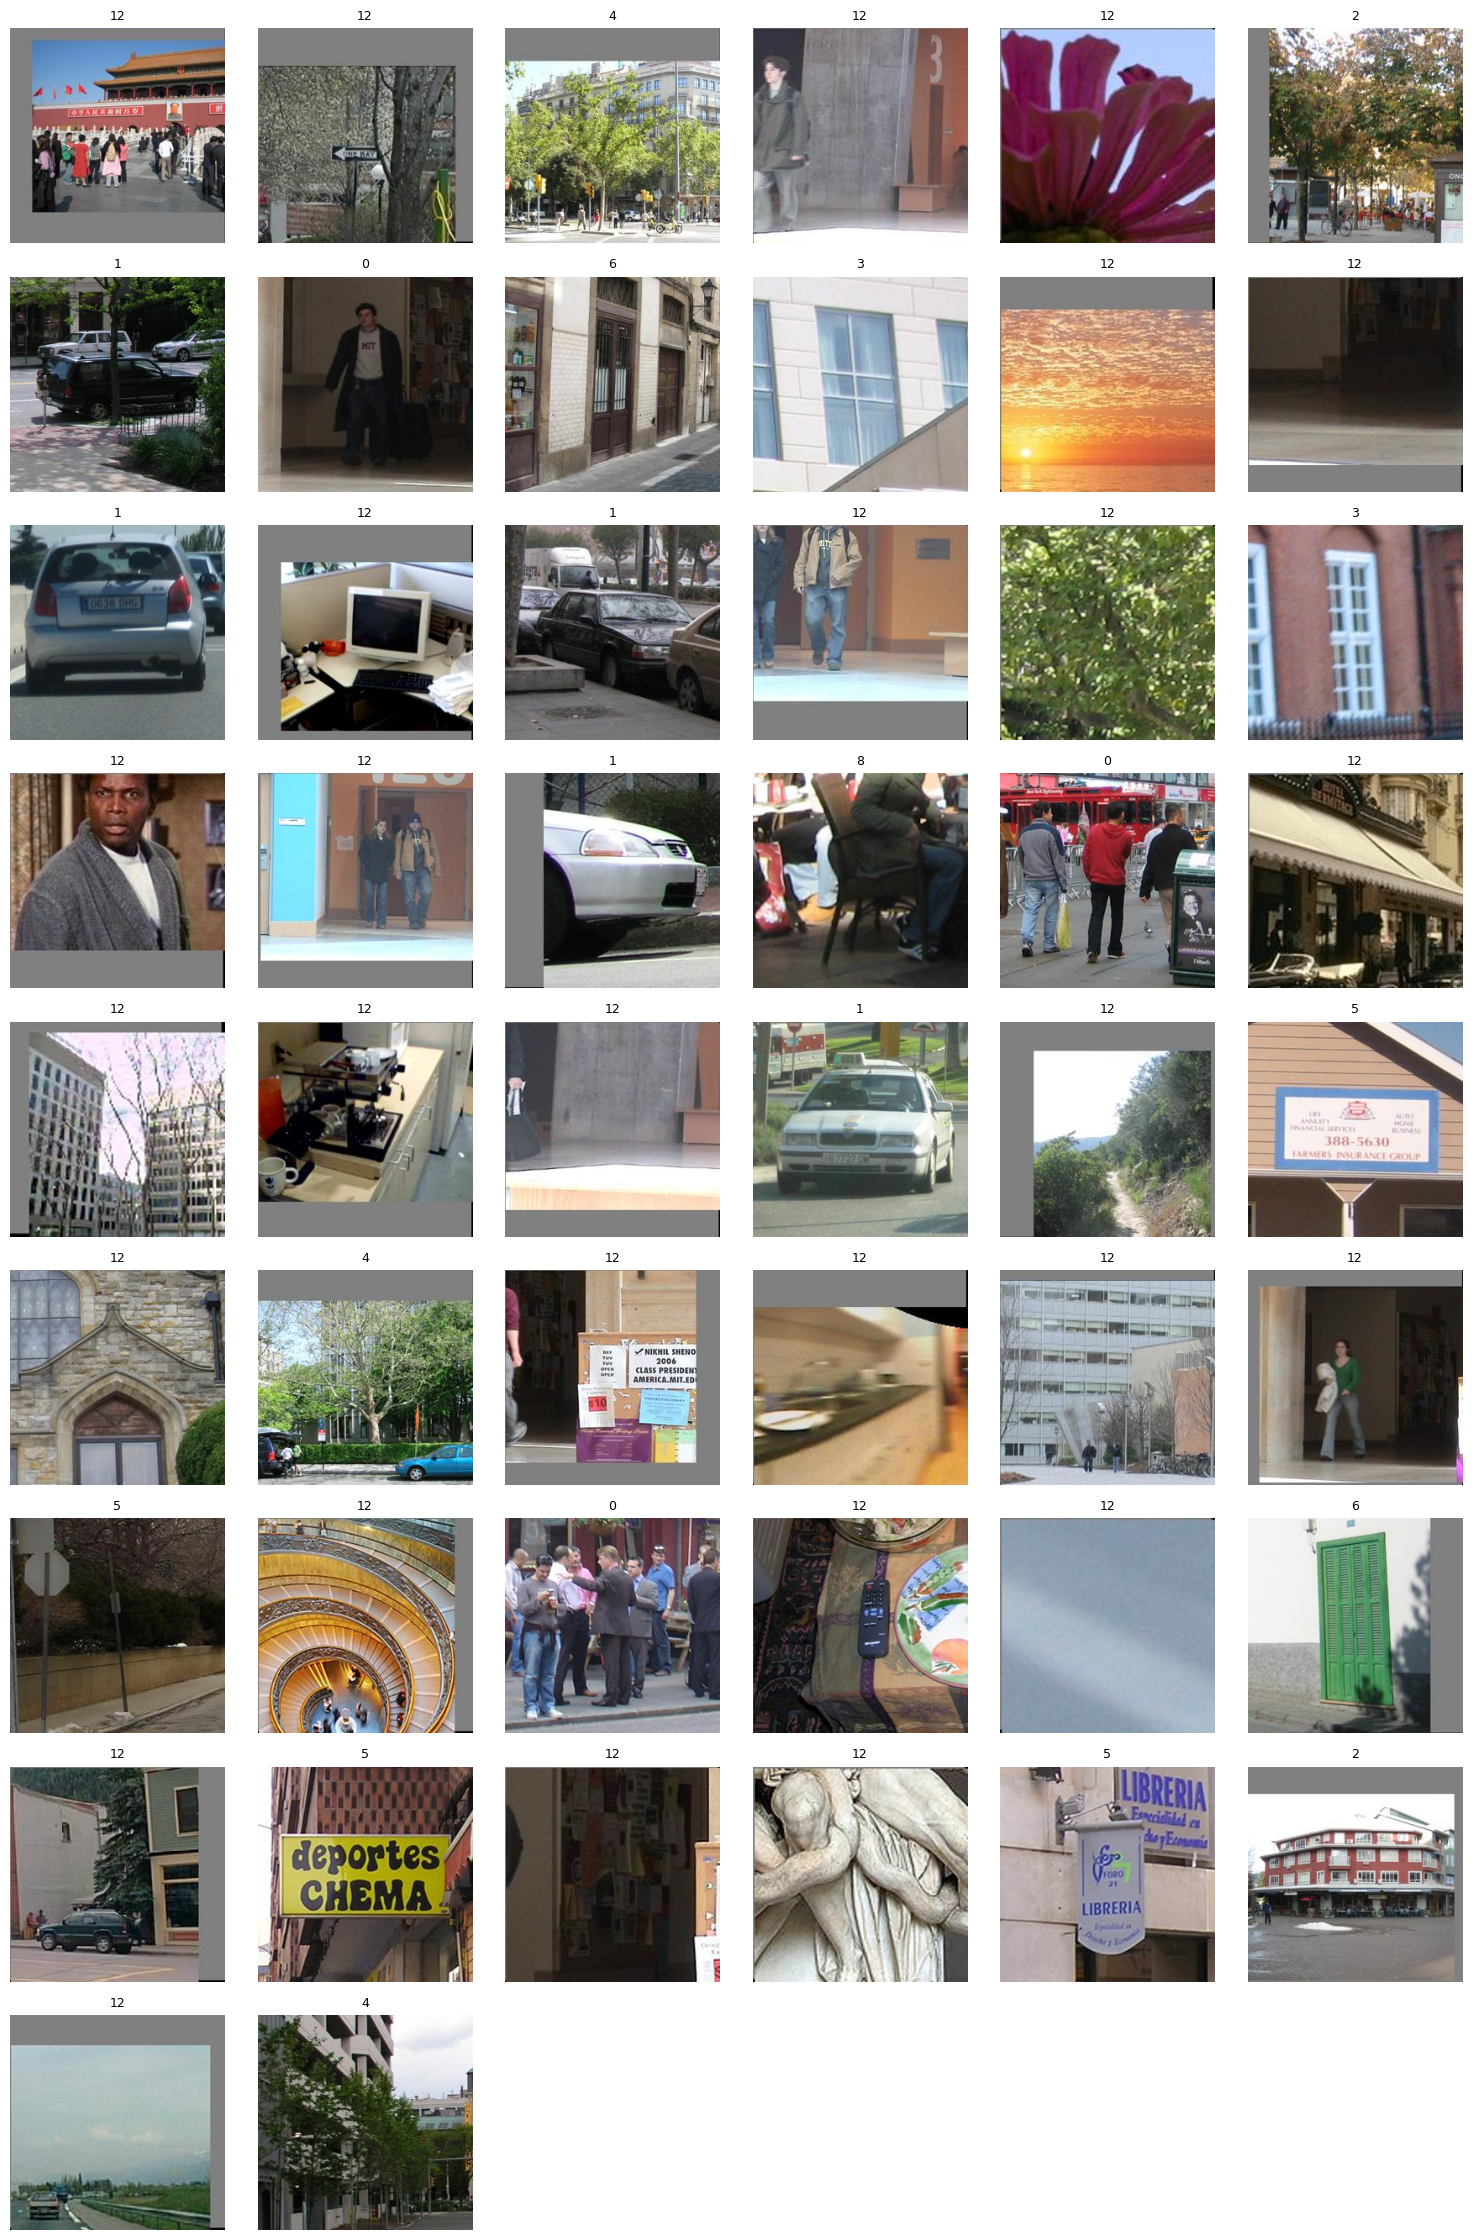

In [ ]:
import math
import matplotlib.pyplot as plt

def ver_grid(df, n=12, cols=4):
    """
    Muestra un grid simple de imágenes con su etiqueta.
    Requiere columnas: 'img_path' y 'str_label' en df.
    """
    sel = df.sample(n=min(n, len(df))).reset_index(drop=True)
    rows = math.ceil(len(sel) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    axes = axes.ravel() if rows*cols > 1 else [axes]

    for i, row in sel.iterrows():
        ax = axes[i]
        ax.imshow(plt.imread(row["image"]))
        ax.set_title(str(row["label"]), fontsize=9)
        ax.axis("off")

    # Oculta ejes sobrantes si no se llenó el grid
    for j in range(len(sel), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

ver_grid(train_df, 50, 6)

In [ ]:
! pip install autogluon

In [ ]:
# Celda 5 — split estratificado 70/15/15
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train_df, test_size=0.20, stratify=train_df["label"], random_state=42)


In [ ]:
from autogluon.multimodal import MultiModalPredictor

In [ ]:
predictor = MultiModalPredictor(problem_type="multiclass", label='label')

In [ ]:
hparams = {
    "model.names" : ["timm_image"],
    "model.timm_image.checkpoint_name": "resnet50",
    "optim.lr_choice": "two_stages",
    "optim.lr_mult": 50,
    "optim.lr": 1e-4,
    "optim.max_epochs": 2,
    "optim.patience": 5
}

In [ ]:
predictor.fit(
    hyperparameters = hparams,
    presets = "medium_quality",
    train_data = df_train,
    tuning_data = df_val
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251005_002855"
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Count:          1
Memory Avail:       7.14 GB / 12.67 GB (56.4%)
Disk Space Avail:   26.21 GB / 73.59 GB (35.6%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/AutogluonModels/ag-20251005_002855
    ```

INFO: Seed set to 0


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name              | Type                            | Params | Mode 
------------------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 23.5 M | train
1 | validation_metric | MulticlassAccuracy              | 0      | train
2 | loss_func         | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------------------
23.5 M    Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 125: 'val_accuracy' reached 0.79913 (best 0.79913), saving model to '/content/AutogluonModels/ag-20251005_002855/epoch=0-step=125.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 250: 'val_accuracy' reached 0.84900 (best 0.84900), saving model to '/content/AutogluonModels/ag-20251005_002855/epoch=0-step=250.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 375: 'val_accuracy' reached 0.87187 (best 0.87187), saving model to '/content/AutogluonModels/ag-20251005_002855/epoch=1-step=375.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 500: 'val_accuracy' reached 0.87587 (best 0.87587), saving model to '/content/AutogluonModels/ag-20251005_002855/epoch=1-step=500.ckpt' as top 3
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20251005_002855")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [ ]:
predictor.evaluate(df_val)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

{'accuracy': 0.876}

In [ ]:
predictor.evaluate(test_df)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
tensorboard --logdir /content/AutogluonModels/ag-20251005_002855# Mirar cómo se ejecuta el tensorboard
# ! tensorboard --logdir /content/AutogluonModels/ag-20251005_002855

### 1. Pretrainer model Choes
### 2. Inicio del modelo
### 3. Adaptación de los tapones finales
### 4. Ajuste fino
### 5. Evaluación y ajustes
### 6. Exploración